In [14]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn import metrics
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

pd.options.display.max_rows = 80

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

In [3]:
columns_quant = ['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']

columns_cat = ['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']

X_quant = df[columns_quant]
X_quant_scaled = StandardScaler().fit_transform(X_quant)
print(len(X_quant.columns))
display(X_quant.columns)

X_quant_cat = df[columns_quant + columns_cat]
X_quant_cat = pd.get_dummies(X_quant_cat, columns=columns_cat, drop_first=True)
X_quant_cat_scaled = StandardScaler().fit_transform(X_quant_cat)
print(len(X_quant_cat.columns))
display(X_quant_cat.columns)

y = df['is_display_clicked']

13


Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')

63


Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro', 'display_env_app_ios', 'display_env_other',
       'display_env_web', 'target_env_2', 'campaignscenario_5',
       'campaignscenario_6', 'campaignscenario_11', 'campaignscenario_12',
       'campaignscenario_13', 'campaignscenario_17', 'campaignvertical_20.0',
       'campaignvertical_23.0', 'campaignvertical_129.0',
       'campaignvertical_200002.0', 'is_interstitial_True',
       'device_type_Desktop', 'device_type_Desktop - Safari',
       'device_type_Mobile - Other', 'device_type_Unknown', 'device_type_iPad',
       'device_type_iPhone', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_

## Méthode RFE

L'avantage de cette méthode est qu'elle dépend du modèle utilisé.

In [4]:
def run_RFE(model, n_features_to_select, X, y, X_columns=False):
    # create the RFE model and select 3 attributes
    rfe = RFE(model, n_features_to_select=3)
    rfe = rfe.fit(X, y)

    # summarize the selection of the attributes
    #  print(rfe.support_)
    #  print(rfe.ranking_)
    
    if type(X_columns) == bool:
        X_columns = X.columns

    rf_df = pd.DataFrame(rfe.ranking_,index=X_columns, columns=['Rank']).sort_values(by='Rank', ascending=True)

    display(rf_df)

In [5]:
%%time
model = LogisticRegression()
run_RFE(model, 8, X_quant_scaled, y, X_columns=X_quant.columns)

,Rank
campaignctrlast24h,1
display_size,1
zonecostineuro,1
nbdisplay_1hour,2
nbdayssincelastclick,3
nbdisplayglobalapprox_1d_sum_xdevice,4
dayssincelastvisitdouble,5
ltf_nbpartnerdisplayssincelastclick,6
ltf_nbpartnerclick_90d,7
contextid,8


Wall time: 18.1 s


In [6]:
%%time
model = LogisticRegression()
run_RFE(model, 3, X_quant_scaled, y, X_columns=X_quant.columns)

,Rank
campaignctrlast24h,1
display_size,1
zonecostineuro,1
nbdisplay_1hour,2
nbdayssincelastclick,3
nbdisplayglobalapprox_1d_sum_xdevice,4
dayssincelastvisitdouble,5
ltf_nbpartnerdisplayssincelastclick,6
ltf_nbpartnerclick_90d,7
contextid,8


Wall time: 19.5 s


In [7]:
%%time
model = LogisticRegression()
run_RFE(model, 2, X_quant_scaled, y, X_columns=X_quant.columns)

,Rank
campaignctrlast24h,1
display_size,1
zonecostineuro,1
nbdisplay_1hour,2
nbdayssincelastclick,3
nbdisplayglobalapprox_1d_sum_xdevice,4
dayssincelastvisitdouble,5
ltf_nbpartnerdisplayssincelastclick,6
ltf_nbpartnerclick_90d,7
contextid,8


Wall time: 22.5 s


Pour ne pas avoir à définir un nombre de features, nous allons utiliser une méthode de Cross Validation qui permettra de calculer le nombre de features optimal.

## Méthode RFECV

In [8]:
def run_RFECV(model, min_features_to_select, X, y):

    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5),
                  scoring='recall',
                  min_features_to_select=min_features_to_select,
                  n_jobs=-1)
    rfecv.fit(X, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (recall)")
    plt.plot(range(min_features_to_select,
                   len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_)
    plt.show()

### Variables quantitatives

Optimal number of features : 12


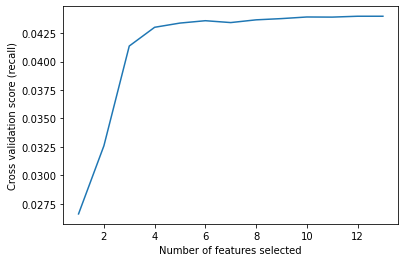

Wall time: 49.4 s


In [9]:
%%time
model = LogisticRegression()
run_RFECV(model, 1, X_quant_scaled, y)

Le nombre de features optimal semble être 4. Nous allons donc maintenant calculer une RFE avec cette valeur pour déterminer les features à conserver.

In [10]:
%%time
model = LogisticRegression()
run_RFE(model, 4, X_quant_scaled, y, X_columns=X_quant.columns)

,Rank
campaignctrlast24h,1
display_size,1
zonecostineuro,1
nbdisplay_1hour,2
nbdayssincelastclick,3
nbdisplayglobalapprox_1d_sum_xdevice,4
dayssincelastvisitdouble,5
ltf_nbpartnerdisplayssincelastclick,6
ltf_nbpartnerclick_90d,7
contextid,8


Wall time: 22.4 s


### Variables quantitatives + catégorielles

Rajoutons à présent les variables catégorielles.

Optimal number of features : 46


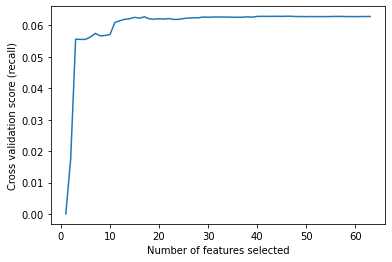

Wall time: 14min 40s


In [11]:
%%time
model = LogisticRegression()
run_RFECV(model, 1, X_quant_cat_scaled, y)

Le nombre de features optimal semble être 11. Nous allons donc maintenant calculer une RFE avec cette valeur pour déterminer les features à conserver.

In [15]:
%%time
model = LogisticRegression()
run_RFE(model, 11, X_quant_cat_scaled, y, X_columns=X_quant_cat.columns)

,Rank
campaignctrlast24h,1
zonecostineuro,1
is_interstitial_True,1
nbdisplay_1hour,2
device_type_Desktop,3
device_type_iPhone,4
display_env_app_ios,5
target_env_2,6
campaignscenario_13,7
nbdayssincelastclick,8


Wall time: 4min 44s


In [13]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:21:51
